# Legal Text Decoder - Data Exploration

**Deep Learning Class (VITMMA19) Project Work**

Ez a notebook a Legal Text Decoder projekt adatfeltáró elemzését tartalmazza.

**Feladat**: ÁSZF bekezdések érthetőségének predikciója (1-5 skála)
- **1**: Nagyon nehezen érthető
- **2**: Nehezen érthető
- **3**: Többé/kevésbé megértem
- **4**: Érthető
- **5**: Könnyen érthető

**Adatok**:
- Tanító adat: `budapestgo_aszf.json`
- Teszt adat: `consensus/*.json` (annotátorok konszenzusa)

## 1. Import Required Libraries

In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import glob
import warnings
warnings.filterwarnings('ignore')

# Beállítások
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print("Könyvtárak importálva")

Könyvtárak importálva


## 2. Data Loading and Exploration

In [11]:
def load_annotations(file_path):
    """
    Betölti a JSON annotációkat és egy DataFrame-be konvertálja.
    Label Studio formátum kezelése.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    if not data:
        return pd.DataFrame(columns=['text', 'rating'])
    
    filtered_data = []
    
    for item in data:
        try:
            text = item.get('data', {}).get('text', '')
            rating = None
            
            if 'annotations' in item and len(item['annotations']) > 0:
                annotations = item['annotations'][0]
                if 'result' in annotations and len(annotations['result']) > 0:
                    result = annotations['result'][0]
                    if 'value' in result and 'choices' in result['value']:
                        choices = result['value']['choices']
                        if len(choices) > 0:
                            rating_str = choices[0]
                            if rating_str and rating_str[0].isdigit():
                                rating = int(rating_str[0])
            
            if rating is not None and text:
                filtered_data.append({'text': text, 'rating': rating})
        except Exception as e:
            continue
    
    return pd.DataFrame(filtered_data)

print(" Adatbetöltő függvény definiálva")

 Adatbetöltő függvény definiálva


In [12]:
# Tanító adat betöltése
train_file = Path('../budapestgo_aszf.json')
train_df = load_annotations(train_file)

print(f"Tanító adat (budapestgo_aszf.json): {len(train_df)} bekezdés")

if len(train_df) > 0:
    print(f"\nRating eloszlás:")
    print(train_df['rating'].value_counts().sort_index())
    print(f"\nStatisztikák:")
    print(train_df['rating'].describe())
else:
    print(" A tanító fájl üres, a consensus adatokat használjuk")

Tanító adat (budapestgo_aszf.json): 133 bekezdés

Rating eloszlás:
rating
1     4
2     6
3    28
4    37
5    58
Name: count, dtype: int64

Statisztikák:
count    133.000000
mean       4.045113
std        1.050719
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64


In [13]:
# Konszenzus adatok betöltése
consensus_files = glob.glob('../consensus/*.json')
consensus_files = [f for f in consensus_files if 'legaltextdecoder' not in f.lower()]

print(f"Konszenzus fájlok száma: {len(consensus_files)}")

consensus_data = []
file_info = []

for file_path in consensus_files:
    try:
        df = load_annotations(file_path)
        if len(df) > 0:
            file_name = Path(file_path).stem
            df['source'] = file_name
            consensus_data.append(df)
            file_info.append({
                'Fájl': file_name,
                'Bekezdések': len(df),
                'Átlag rating': df['rating'].mean()
            })
    except Exception as e:
        print(f" Hiba {Path(file_path).stem} betöltésekor: {e}")

if consensus_data:
    consensus_df = pd.concat(consensus_data, ignore_index=True)
    print(f"\n Összes konszenzus adat: {len(consensus_df)} bekezdés")
    print(f"  Annotátorok száma: {len(consensus_data)}")
    
    # Annotátor statisztikák
    print("\nAnnotátor részletek:")
    print(pd.DataFrame(file_info).sort_values('Bekezdések', ascending=False).to_string(index=False))

Konszenzus fájlok száma: 30
 Hiba BP17IB betöltésekor: Expecting value: line 1 column 1 (char 0)

 Összes konszenzus adat: 2415 bekezdés
  Annotátorok száma: 28

Annotátor részletek:
  Fájl  Bekezdések  Átlag rating
EKGPBX         269      3.460967
LXXAMS         141      4.226950
XQEBMQ         141      3.638298
Q88P3E         141      3.751773
LWVUH9         141      4.120567
FA0B9B         140      3.214286
WFXBHI         135      3.866667
KRR9OD         134      3.574627
HW921K         133      3.827068
TFH22P         132      4.068182
I1TLYH         132      3.242424
SS0N7G         102      3.549020
Z7ZF6D          87      3.827586
BCLHKC          78      3.435897
MHY664          69      3.420290
HV75KB          68      3.485294
MDKFWC          55      3.727273
T989VT          47      4.042553
NHVU6N          46      3.000000
K3I7DL          40      3.375000
QG1L1V          30      4.100000
R92D9T          28      3.642857
j0r9ys          27      3.703704
G1QFG2          26      3

## 3. Label Distribution Analysis

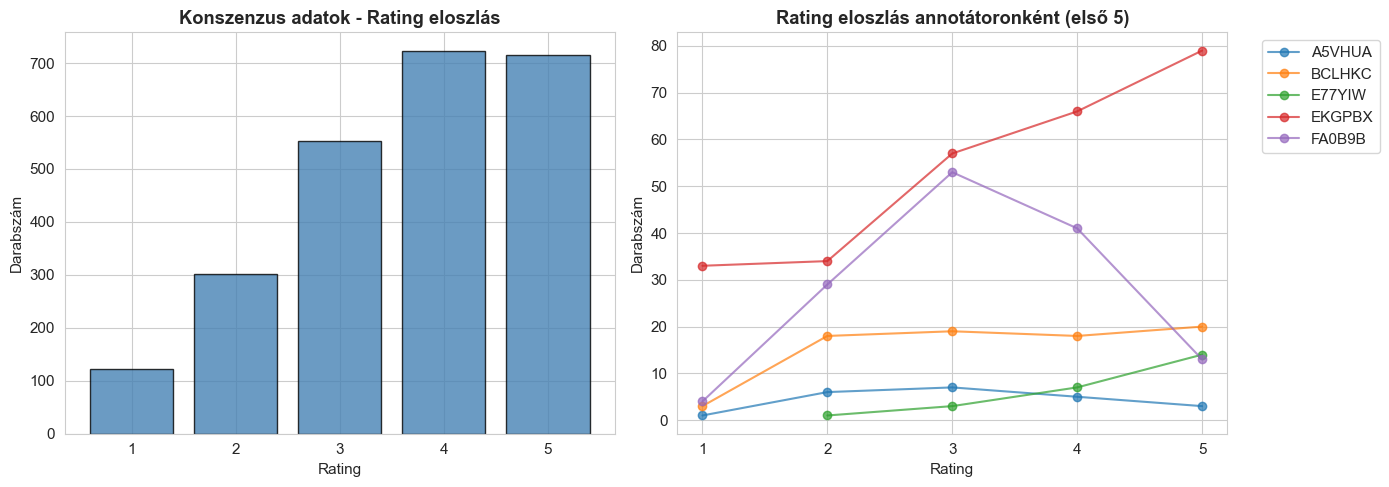


Rating eloszlás (konszenzus):
  Rating 1:  123 (  5.1%)
  Rating 2:  302 ( 12.5%)
  Rating 3:  553 ( 22.9%)
  Rating 4:  722 ( 29.9%)
  Rating 5:  715 ( 29.6%)


In [14]:
# Rating eloszlás vizualizáció
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Konszenzus adat eloszlás
consensus_counts = consensus_df['rating'].value_counts().sort_index()
axes[0].bar(consensus_counts.index, consensus_counts.values, 
            color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Darabszám')
axes[0].set_title('Konszenzus adatok - Rating eloszlás', fontweight='bold')
axes[0].set_xticks([1, 2, 3, 4, 5])

# Annotátoronkénti eloszlás
for annotator in consensus_df['source'].unique()[:5]:  # Első 5 annotátor
    subset = consensus_df[consensus_df['source'] == annotator]
    counts = subset['rating'].value_counts().sort_index()
    axes[1].plot(counts.index, counts.values, 'o-', label=annotator, alpha=0.7)

axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Darabszám')
axes[1].set_title('Rating eloszlás annotátoronként (első 5)', fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

# Összesített statisztikák
print("\nRating eloszlás (konszenzus):")
for rating in range(1, 6):
    count = (consensus_df['rating'] == rating).sum()
    pct = count / len(consensus_df) * 100
    print(f"  Rating {rating}: {count:4d} ({pct:5.1f}%)")

## 4. Text Statistics and Complexity Analysis

In [15]:
# Szöveg statisztikák kiszámítása
import re

def calc_text_stats(text):
    """Szöveg komplexitási jellemzők kiszámítása."""
    char_count = len(text)
    words = text.split()
    word_count = len(words)
    sentences = re.split(r'[.!?]+', text)
    sentence_count = len([s for s in sentences if s.strip()])
    
    if word_count == 0:
        return {'char_count': 0, 'word_count': 0, 'sentence_count': 0,
                'avg_word_len': 0, 'avg_sent_len': 0}
    
    avg_word_len = np.mean([len(w) for w in words])
    avg_sent_len = word_count / max(sentence_count, 1)
    
    # Hosszú szavak aránya
    long_word_ratio = len([w for w in words if len(w) > 6]) / word_count
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_len': avg_word_len,
        'avg_sent_len': avg_sent_len,
        'long_word_ratio': long_word_ratio
    }

# Statisztikák kiszámítása
stats_list = [calc_text_stats(text) for text in consensus_df['text']]
stats_df = pd.DataFrame(stats_list)
consensus_df = pd.concat([consensus_df.reset_index(drop=True), stats_df], axis=1)

print("Szöveg statisztikák:")
print(consensus_df[['char_count', 'word_count', 'sentence_count', 'avg_word_len']].describe())

Szöveg statisztikák:
        char_count   word_count  sentence_count  avg_word_len
count  2415.000000  2415.000000     2415.000000   2415.000000
mean    348.801656    44.096894        3.640580      7.047191
std     341.555787    41.812039        3.106773      0.852132
min      15.000000     2.000000        1.000000      4.333333
25%     175.000000    22.000000        2.000000      6.483333
50%     297.000000    37.000000        3.000000      6.937500
75%     439.000000    54.000000        4.000000      7.476190
max    4336.000000   513.000000       65.000000     10.888889


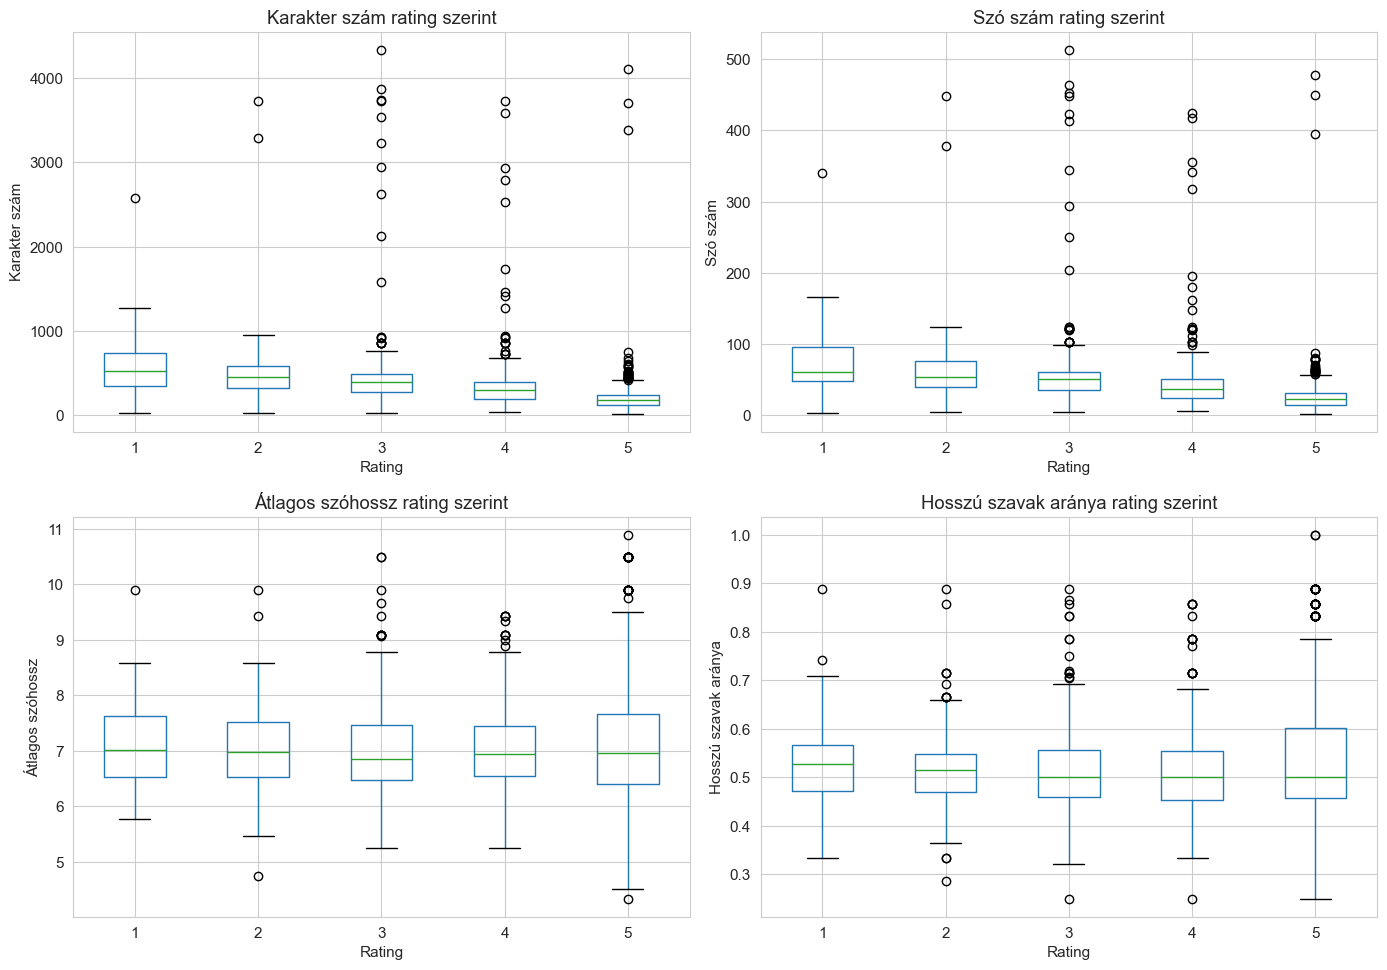


Korrelációk a rating-gel:
  char_count: -0.3304
  word_count: -0.3400
  avg_word_len: 0.0454
  long_word_ratio: 0.0683


In [16]:
# Szöveg komplexitás és rating kapcsolata
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Karakter szám vs Rating
consensus_df.boxplot(column='char_count', by='rating', ax=axes[0, 0])
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Karakter szám')
axes[0, 0].set_title('Karakter szám rating szerint')
plt.suptitle('')

# Szó szám vs Rating
consensus_df.boxplot(column='word_count', by='rating', ax=axes[0, 1])
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Szó szám')
axes[0, 1].set_title('Szó szám rating szerint')
plt.suptitle('')

# Átlagos szóhossz vs Rating
consensus_df.boxplot(column='avg_word_len', by='rating', ax=axes[1, 0])
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Átlagos szóhossz')
axes[1, 0].set_title('Átlagos szóhossz rating szerint')
plt.suptitle('')

# Hosszú szavak aránya vs Rating
consensus_df.boxplot(column='long_word_ratio', by='rating', ax=axes[1, 1])
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Hosszú szavak aránya')
axes[1, 1].set_title('Hosszú szavak aránya rating szerint')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Korrelációk
print("\nKorrelációk a rating-gel:")
for col in ['char_count', 'word_count', 'avg_word_len', 'long_word_ratio']:
    corr = consensus_df[col].corr(consensus_df['rating'])
    print(f"  {col}: {corr:.4f}")

## 5. Sample Texts by Rating Category

In [17]:
# Minta szövegek minden rating kategóriához
rating_labels = {
    1: 'Nagyon nehezen érthető',
    2: 'Nehezen érthető',
    3: 'Többé/kevésbé megértem',
    4: 'Érthető',
    5: 'Könnyen érthető'
}

for rating in range(1, 6):
    samples = consensus_df[consensus_df['rating'] == rating]['text'].head(2)
    print(f"\n{'='*70}")
    print(f"RATING {rating}: {rating_labels[rating]}")
    print('='*70)
    for i, text in enumerate(samples, 1):
        print(f"\n[{i}] {text[:300]}{'...' if len(text) > 300 else ''}")


RATING 1: Nagyon nehezen érthető

[1] 8. Az OTP Bank Nyrt. nem Magyarország területén, illetve nem Magyarország joghatósága alatt kiállított közokiratot - nemzetközi szerződés eltérő rendelkezése hiányában – kizárólag diplomáciai felülhitelesítéssel ellátott vagy a külföldön felhasználásra kerülő közokiratok diplomáciai vagy konzuli hit...

[2] 8. Az OTP Bank Nyrt. a nem Magyarország területén, és nem Magyarország joghatósága alatt készült meghatalmazást a III.8-9. pontban meghatározott formában fogad el. Az OTP Bank Nyrt. a külügyekért felelős miniszter által arra felhatalmazott konzul készítette konzuli tanúsítványt, valamint az arra fel...

RATING 2: Nehezen érthető

[1] 5. Az OTP Bank Nyrt. jogosult meggyőződni az Ügyfél képviselőjének képviseleti jogáról. E célból kérheti, hogy az Ügyfél képviselője képviseleti jogát hitelt érdemlően igazolja. Az OTP Bank Nyrt. a hozzá bejelentett képviselőket mindaddig az Ügyfél képviselőjének tekinti, amíg a képviseleti jog viss...

[2] 8. Az O

## 6. Summary and Key Findings

In [18]:
# Összefoglaló
print("="*70)
print("LEGAL TEXT DECODER - DATA EXPLORATION SUMMARY")
print("="*70)

print(f"\n ADATOK:")
print(f"  • Konszenzus minták: {len(consensus_df)}")
print(f"  • Annotátorok száma: {len(consensus_data)}")

most_frequent = consensus_df['rating'].mode()[0]
print(f"\n LABEL ELOSZLÁS:")
print(f"  • Leggyakoribb osztály: {most_frequent}")
print(f"  • Osztály eloszlás kiegyensúlyozatlan: {consensus_df['rating'].value_counts().values}")

print(f"\n SZÖVEG JELLEMZŐK:")
print(f"  • Átlagos szöveghossz: {consensus_df['char_count'].mean():.0f} karakter")
print(f"  • Átlagos szószám: {consensus_df['word_count'].mean():.1f} szó")
print(f"  • Átlagos szóhossz: {consensus_df['avg_word_len'].mean():.2f} karakter")

print(f"\n KÖVETKEZTETÉSEK:")
print(f"  • A szöveg komplexitás (hossz, szóhossz) korrelál az érthetőséggel")
print(f"  • A hosszabb, bonyolultabb szövegek nehezebben érthetőek")
print(f"  • Feature engineering: karakterszám, szóhossz, jogi terminológia")

LEGAL TEXT DECODER - DATA EXPLORATION SUMMARY

 ADATOK:
  • Konszenzus minták: 2415
  • Annotátorok száma: 28

 LABEL ELOSZLÁS:
  • Leggyakoribb osztály: 4
  • Osztály eloszlás kiegyensúlyozatlan: [722 715 553 302 123]

 SZÖVEG JELLEMZŐK:
  • Átlagos szöveghossz: 349 karakter
  • Átlagos szószám: 44.1 szó
  • Átlagos szóhossz: 7.05 karakter

 KÖVETKEZTETÉSEK:
  • A szöveg komplexitás (hossz, szóhossz) korrelál az érthetőséggel
  • A hosszabb, bonyolultabb szövegek nehezebben érthetőek
  • Feature engineering: karakterszám, szóhossz, jogi terminológia
